# FIND BELOW THE (RECURRENT) RANDOM FOREST ANALYSIS

# Install Packages

In [1]:
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable collapsible_headings/main
# !pip install astropy
# !pip install seaborn
# !pip install site

# Import Packages

In [1]:
#astrology packages
from astropy.table import Table
import astropy.coordinates as coord
import glob
from astropy import units as u
from astroquery.gaia import Gaia


#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections
import copy

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import RandomizedSearchCV

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef

#for my sanity
import warnings
warnings.filterwarnings('ignore')

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Define Relevant Non-Model Functions

In [4]:
#This function helps us obtain a set of relevant background points for any given stellar stream
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

# For each mock stream, we wish to obtain a fixed test set that represents the realistic ratio of non-stream stars to stream stars
def obtain_test_set(list_of_stellar_streams, multiple):

    for i in list_of_stellar_streams:
        table = Table.read(i, format='fits')
        stream = table.to_pandas()
        
        idx = cuts.index[cuts.stream_file==str(i)][0]

        ra_min = cuts.loc[idx].ra_min
        ra_max = cuts.loc[idx].ra_max
        dec_min = cuts.loc[idx].dec_min
        dec_max = cuts.loc[idx].dec_max
        
        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #obtain noise points such that:
        #- the ratio of stream to noise points in the test set is 1:multiple
        #- this is required because KNN introduces bias when the ratios are imbalanced
        n_points = len(stream) * multiple
        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False
        
        #send to csv
        name = i[18:-8]+'_mul_400_total_noise.csv'
        noise_points.to_csv(name)

    return noise_points

# Define Relevant Model Functions

In [2]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test, threshold_log):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='ovr').fit(X_train, y_train)
    
    THRESHOLD = threshold_log
    y_pred = np.where(log_reg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#defaults for hyperparameters are set to match those used in sklearn
def random_forest_model(X_train, X_test, y_train, y_test, n_trees = 100, criterion = "gini", max_depth = None,
                       min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, max_features = "auto", 
                        max_leaf_nodes = None, min_impurity_split = 1e-7, bootstrap = True,
                        oob_score = False, n_jobs = None, random_state = None, verbose = 0, warm_start = False, class_weight = {0:1,1:1}):
    #do the random forest modeling
    random_forest = RandomForestClassifier(
                                            n_estimators = n_trees, criterion = criterion, 
                                            max_depth = max_depth, min_samples_split = min_samples_split, 
                                            min_samples_leaf = min_samples_leaf, 
                                            min_weight_fraction_leaf = min_weight_fraction_leaf, 
                                            max_features = max_features, max_leaf_nodes = max_leaf_nodes,  
                                            min_impurity_split = min_impurity_split, bootstrap = bootstrap, 
                                            oob_score = oob_score, n_jobs = n_jobs, 
                                            random_state = random_state, verbose = verbose, warm_start = False,
                                            class_weight = {0:weight_0,1:weight_1}
                                          ).fit(X_train, y_train)
    
    y_pred = random_forest.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true, random_forest

#defaults for hyperparameters are set to match those used in sklearn
def gradient_boost_model(X_train, X_test, y_train, y_test, loss = 'deviance', learning_rate = 0.1, n_estimators = 100, 
                         subsample = 1.0, criterion = "friedman_mse", min_samples_split = 2, 
                         min_samples_leaf = 1, min_weight_fraction_leaf = 0., max_depth = 3, 
                         min_impurity_decrease = 0, min_impurity_split = 1e-7, init = None,
                         random_state = None, max_features = None, max_leaf_nodes = None, verbose = 0,
                         warm_start  = False): #validation_fraction = 0.1, 
                         #n_iter_no_change = None, tol = 1e-4, ccp_alpha = 0.0):
    #do the gradient boosting modeling
    gradient_boost = GradientBoostingClassifier(
                                                loss = loss, learning_rate = learning_rate, 
                                                n_estimators = n_estimators, 
                                                subsample = subsample, criterion = criterion, 
                                                min_samples_split = min_samples_split, 
                                                min_samples_leaf = min_samples_leaf, 
                                                min_weight_fraction_leaf = min_weight_fraction_leaf, 
                                                max_depth = max_depth, 
                                                min_impurity_decrease = min_impurity_decrease, 
                                                min_impurity_split = min_impurity_split, init = init,
                                                random_state = random_state, max_features = max_features, 
                                                max_leaf_nodes = max_leaf_nodes, verbose = verbose,
                                                warm_start = warm_start #validation_fraction = validation_fraction, 
                                                #n_iter_no_change = n_iter_no_change, tol = tol, ccp_alpha = ccp_alpha
                                              ).fit(X_train, y_train)
    
    y_pred = gradient_boost.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#defaults for hyperparameters are set to match those used in sklearn
def one_class_svm_model(X_train, X_test, y_train, y_test, 
                        kernel = 'rbf', degree = 3, gamma = 0.001, 
                        coef0 = 0.0, tol = 0.001, nu = 0.5, shrinking = True, 
                        cache_size = 200, verbose = False, max_iter = -1, random_state = None):
    #do the random forest modeling
    one_class_svm = OneClassSVM(
                                kernel = kernel, degree = degree, gamma = gamma, coef0 = coef0, 
                                tol = tol, nu = nu, shrinking = shrinking, cache_size = cache_size, 
                                verbose = verbose, max_iter = max_iter, random_state = random_state
                               ).fit(X_train, y_train)
    
    y_pred = one_class_svm.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred, average='micro')
    recall = metrics.recall_score(y_true, y_pred, average='micro')
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

# Define Relevant Streams

## Define All Considered Streams

In [5]:
#define all the stellar stream stars that may be used in training and testing
viable_new = ['stream-3775',
 'stream-5489',
 'stream-8137',
 'stream-5406',
 'stream-1698',
 'stream-1667',
 'stream-1012',
 'stream-532',
 'stream-178',
 'stream-9528',
 'stream-2805',
 'stream-247',
 'stream-4717',
 'stream-5402',
 'stream-5713',
 'stream-1519',
 'stream-4807',
 'stream-1101']

## Define Streams to Constitute Validation Set

In [9]:
#From the second half of our test set, we exclude streams that we have independently evaluated to have an insufficient number of relevant stars
#The filtering is done elsewhere use a filter called 'b', which references the density profile of a given area
#viable_new_valid becomes our test set
viable_new_valid = viable_new[:3]+viable_new[4:7]+viable_new[8:9]

## Define Streams to Constitute Test Set

In [34]:
#From the second half of our test set, we exclude streams that we have independently evaluated to have an insufficient number of relevant stars
#The filtering is done elsewhere use a filter called 'b', which references the density profile of a given area
#viable_new2 becomes our test set
viable_new2 = viable_new[9:16]+viable_new[17:]
viable_new2

['stream-9528',
 'stream-2805',
 'stream-247',
 'stream-4717',
 'stream-5402',
 'stream-5713',
 'stream-1519',
 'stream-1101']

# Tune Random Forest Model
#### Uncomment to tune; optimal parameters already displayed in testing phase

In [11]:
# #tuning for threshold
# params= []
# f1_vals = []

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)] #start= 200,stop = 2000, num = 10
# # Number of features to consider at every split
# max_features = ['auto'] #'sqrt'
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 50, num = 3)] #10,110, num = 11
# #max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2,5] #2,5,10
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1,2] #1,2,4
# # Method of selecting samples for training each tree
# bootstrap = [True] #False

# total = 3 * 1 * 3 * 2 * 2 * 1
# count = 0

# for n_estimator in tqdm(n_estimators):
#     for max_feature in max_features:
#         for depth in max_depth:
#             for min_split in min_samples_split:
#                 for min_leaf in min_samples_leaf:
#                     for bootstrap_option in bootstrap:
#                         count += 1
#                         stream_name_rf = []
#                         true_positives = []
#                         false_positives = []
#                         true_negatives = []
#                         false_negatives = []
#                         y_preds = []
#                         testing_datas = []
#                         multiple = 150

#                         for stream_name in viable_new_valid:

#                             stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
#                             stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

#                             #stars known to model
#                             stream_train = pd.read_csv(stream_primer1, index_col = 0)
#                             stream_train['stream_mask'] = True
#                             #unknown to model
#                             stream_test = pd.read_csv(stream_primer2, index_col = 0)
#                             stream_test['stream_mask'] = True  

#                             #obtain noise points such that:
#                             #- the ratio of stream to noise points in the training set is 1:multiple
#                             #- the ratio of stream to noise points in the test set is close to the 'real' ratio
#                             test_primer = 'stream_stars_split/simulated_noise_points/150_to_1_ratio/'
#                             name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

#                             train_primer = 'stream_stars_split/simulated_noise_points/400_to_1_ratio/'
#                             name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

#                             noise_test = pd.read_csv(name_test, index_col = 0)
#                             noise_points = pd.read_csv(name_train, index_col = 0)

#                             #add back the test points into the muck and assume they're background stars from which to draw
#                             noise_points = noise_points.append(stream_test, ignore_index = False, sort = True)
#                             train_points = len(stream_train) * multiple

#                             #label our data as "not part of the stream"
#                             noise_points['stream_mask'] = False

#                             msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
#                             noise_train = noise_points[msk2]
#                             #noise_test = noise_points[~msk2]



#                             #combine my stream and noise to obtain complete training and test data set
#                             training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
#                             training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

#                             testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
#                             testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

#                             #Convert to Angular Coordinates
#                             #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
#                             #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
#                             #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

#                             deg2rad = lambda deg: deg/180.*np.pi

#                             #Convert data to angular velocities
#                             training_data['ra_rad'] = deg2rad(training_data['ra'])
#                             training_data['dec_rad'] = deg2rad(training_data['dec'])

#                             training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
#                             training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
#                             training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

#                             testing_data['ra_rad'] = deg2rad(testing_data['ra'])
#                             testing_data['dec_rad'] = deg2rad(testing_data['dec'])

#                             testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
#                             testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
#                             testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )


#                             #differentiate training and test data's X and y variables
#                             #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
#                             #y_train = training_data.stream_mask

#                             #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
#                             #y_test = testing_data.stream_mask


#                             #differentiate training and test data's X and y variables
#                             X_train = training_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
#                             y_train = training_data.stream_mask

#                             X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
#                             y_test = testing_data.stream_mask


#                             #scale the features using standard scaler (scaling not required for logistic regression)
#                             scaler = StandardScaler()
#                             X_train_scaled = scaler.fit(X_train).transform(X_train)
#                             X_test_scaled = scaler.fit(X_test).transform(X_test)

#                             precision, recall, accuracy, auc, y_pred, y_true = random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, 
#                                                                                                    n_trees = n_estimator, criterion = "gini", max_depth = depth,
#                                                                                                    min_samples_split = min_split, min_samples_leaf = min_leaf, 
#                                                                                                    min_weight_fraction_leaf = 0, max_features = max_feature, 
#                                                                                                    max_leaf_nodes = None, min_impurity_decrease = 0, 
#                                                                                                    min_impurity_split = 1e-7, bootstrap = bootstrap_option,
#                                                                                                    oob_score = False, n_jobs = 1, 
#                                                                                                    random_state = None, verbose = 0, warm_start = False)


#                             #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
#                             #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
#                             #Truly in Cluster
#                             X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
#                             X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
#                             #Truly not in Cluster
#                             X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
#                             X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)

#                             stream_name_rf.append(stream_name)
#                             true_positives.append(len(X_correct))
#                             false_positives.append(len(X2_incorrect))
#                             true_negatives.append(len(X2_correct))
#                             false_negatives.append(len(X_incorrect))
#                             y_preds.append(y_pred)
#                             testing_datas.append(testing_data)
#                             param = (n_estimator, max_feature, depth, min_split, min_leaf, bootstrap_option)
#                             params.append(param)
#                         if count%3 == 0:
#                             print (str(count) + ' out of ' + str(total) + 'done')

#                         final_result_rf = pd.DataFrame()
#                         final_result_rf['stream']= stream_name_rf
#                         final_result_rf['true_positives']=true_positives
#                         final_result_rf['false_positives']=false_positives
#                         final_result_rf['true_negatives']=true_negatives
#                         final_result_rf['false_negatives']=false_negatives
#                         #final_result['auc'] = aucs
#                         final_result_rf['precision'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_positives)
#                         final_result_rf['recall'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_negatives)
#                         final_result_rf['f1'] = 2*(final_result_rf.precision * final_result_rf.recall)/(final_result_rf.precision + final_result_rf.recall)
#                         beta = 0.1
#                         final_result_rf['f1_prec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
#                         beta = 0.2
#                         final_result_rf['f1_prec_5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
#                         beta = 5
#                         final_result_rf['f1_rec_5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
#                         beta = 10
#                         final_result_rf['f1_rec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)

#                         f1_vals.append(final_result_rf[final_result_rf.index.isin(range(9))].f1.mean())

In [45]:
params_opt = params[f1_vals.index(max(f1_vals))]
print(params_opt)
print(max(f1_vals))

(100, 'auto', 10, 5, 1, True)
0.695986056049877


# Test Random Forest Model

## Define Function for Recursive Portion

In [14]:
def rf_recursion(training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit, X_correct_cum, X2_incorrect_cum):

    stream_name_rf = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150

    weight_1_options = [0.01, 0.05, 0.1, 0.2, 0.5, 1,5,10,20,50,100,150,200,250,300,400,500,750,1000,2000]
    precisions = []
    recalls = []
    f1s_weights = []

    training_streams_2 = []
    testing_streams_2 = []
    correct_X_2 = []
    incorrect_X2_2 = []
    self_labs_2 = []

    original_index = -1

    #for weight_1 in tqdm(weight_1_options):
    for stream_name in tqdm(viable_new2):
        original_index += 1
        stream_train_prev = training_streams[original_index]
        stream_test_prev = testing_streams[original_index]
        X_correct_prev = correct_X[original_index]
        X2_incorrect_prev = incorrect_X2[original_index]


    #     stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
    #     stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
    #     #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
    #     #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

        #stars known to model
        stream_train2 = stream_train_prev.append(stream_test_prev[stream_test_prev.index.isin(X_correct_prev.index)], ignore_index = False)
        stream_train2 = stream_train2.append(stream_test_prev[stream_test_prev.index.isin(X2_incorrect_prev.index)], ignore_index = False)
        stream_train2['stream_mask'] = True

        #unknown to model
        stream_test2 = stream_test_prev[~stream_test_prev.index.isin(X_correct_prev.index)]
        stream_test2['stream_mask'] = True  

        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

        train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

        noise_test = pd.read_csv(name_test, index_col = 0)
        noise_points = pd.read_csv(name_train, index_col = 0)

        #add back the test points into the muck and assume they're background stars from which to draw
        noise_points = noise_points.append(stream_test2, ignore_index = False)
        train_points = len(stream_train2) * multiple

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]

        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train2.append(noise_train, ignore_index = False)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = stream_test2.append(noise_test, ignore_index = False)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = self_labs[original_index]
        testing_data = testing_data[~testing_data.index.isin(X_correct_prev.index)] #TP
        testing_data = testing_data[~testing_data.index.isin(X2_incorrect_prev.index)] #FP

        #Convert to Angular Coordinates
        #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
        #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
        #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

        deg2rad = lambda deg: deg/180.*np.pi

        #Convert data to angular velocities
        training_data['ra_rad'] = deg2rad(training_data['ra'])
        training_data['dec_rad'] = deg2rad(training_data['dec'])

        training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
        training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
        training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )


        testing_data['ra_rad'] = deg2rad(testing_data['ra'])
        testing_data['dec_rad'] = deg2rad(testing_data['dec'])

        testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

        self_labs_2.append(testing_data)


        #differentiate training and test data's X and y variables
        #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_train = training_data.stream_mask

        #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_test = testing_data.stream_mask


        #differentiate training and test data's X and y variables
        #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_train = training_data.stream_mask

        #X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test = testing_data.stream_mask


        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_train).transform(X_test)


        #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
    #     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
    #     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

    #     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
    #     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_train_scaled = np.array(X_train_scaled)

    #     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
    #     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_test_scaled = np.array(X_test_scaled)    

        precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, 
                                                                               n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                               min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                               min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                               max_leaf_nodes = None, 
                                                                               min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                               oob_score = False, n_jobs = 1, 
                                                                               random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1})


        #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
        X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)
        
        X_correct_cum[stream_name] = X_correct_cum[stream_name].append(X_correct, ignore_index = False)
        #X_incorrect = X_incorrect_cum.append(X_incorrect, ignore_index = False, sort = True)
        #X2_correct_cum.append(X2_correct, ignore_index = False, sort = True)
        X2_incorrect_cum[stream_name] = X2_incorrect_cum[stream_name].append(X2_incorrect, ignore_index = False)
        X_incorrect_cum[stream_name]=X_incorrect
#         if plot_permit == 'yes':
#             X_correct_cum[stream_name]['species']='TP'
#             X_incorrect_cum[stream_name]['species']='FN'
#             X2_incorrect_cum[stream_name]['species']='FP'

#             sns_frame = X_correct_cum[stream_name].append(X_incorrect_cum[stream_name], ignore_index = False, sort = True)
#             sns_frame = sns_frame.append(X2_incorrect_cum[stream_name], ignore_index = False, sort = True)

#             sns_frame = sns_frame[['ra','dec','pmra','pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'species']]

#             g = sns.pairplot(sns_frame, hue = 'species')
#             g.fig.suptitle('Pairwise Plot for ' + stream_name, y = 1.08)
        
        stream_name_rf.append(stream_name)
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))
        y_preds.append(y_pred)
        testing_datas.append(testing_data)
        training_datas.append(training_data)
        training_streams_2.append(stream_train2)
        testing_streams_2.append(stream_test2)
        correct_X_2.append(X_correct)
        incorrect_X2_2.append(X2_incorrect)

    final_result_rf2 = pd.DataFrame()
    final_result_rf2['stream']= stream_name_rf
    final_result_rf2['true_positives']=true_positives+recursive_frames[(len(recursive_frames)-1)].true_positives
    final_result_rf2['false_positives']=false_positives+recursive_frames[(len(recursive_frames)-1)].false_positives
    final_result_rf2['true_negatives']=true_negatives
    final_result_rf2['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf2['precision'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_positives)
    final_result_rf2['recall'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_negatives)
    final_result_rf2['f1'] = 2*(final_result_rf2.precision * final_result_rf2.recall)/(final_result_rf2.precision + final_result_rf2.recall)
#     beta = 0.1
#     final_result_rf2['f1_prec_10'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 0.5
    final_result_rf2['f0.5'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 2
    final_result_rf2['f2'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    final_result_rf2['bal_acc']= (final_result_rf2.true_positives/(final_result_rf2.true_positives + final_result_rf2.false_negatives)+ final_result_rf2.true_negatives/(final_result_rf2.true_negatives+final_result_rf2.false_positives))/2
    final_result_rf2['matt_coef'] = (final_result_rf2.true_positives * final_result_rf2.true_negatives - final_result_rf2.false_positives * final_result_rf2.false_negatives)/((final_result_rf2.true_positives + final_result_rf2.false_positives)*(final_result_rf2.true_positives + final_result_rf2.false_negatives)*(final_result_rf2.true_negatives + final_result_rf2.false_positives)*(final_result_rf2.true_negatives + final_result_rf2.false_negatives))**0.5
    #     precisions.append(final_result_rf.mean().precision)
    #     recalls.append(final_result_rf.mean().recall)
    #     f1s_weights.append(final_result_rf.mean().f1)

    #     recursive_frames.append(final_result_rf2)

    return training_streams_2, testing_streams_2, correct_X_2, incorrect_X2_2, self_labs_2, final_result_rf2, X_correct_cum, X2_incorrect_cum, forest
    

## Run Recursive Random Forest

100%|██████████| 7/7 [00:10<00:00,  1.41s/it]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

 29%|██▊       | 2/7 [00:05<00:10,  2.05s/it]

 43%|████▎     | 3/7 [00:10<00:11,  2.96s/it]

 57%|█████▋    | 4/7 [00:11<00:07,  2.35s/it]

 71%|███████▏  | 5/7 [00:12<00:03,  1.89s/it]

 86%|████████▌ | 6/7 [00:13<00:01,  1.79s/it]

100%|██████████| 7/7 [00:17<00:00,  2.23s/it]


  7%|▋         | 1/14 [00:17<03:42, 17.12s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:01<00:06,  1.07s/it]

 29%|██▊       | 2/7 [00:06<00:11,  2.25s/it]

 43%|████▎     | 3/7 [00:11<00:12,  3.16s/it]

 57%|█████▋    | 4/7 [00:12<00:07,  2.52s/it]

 71%|███████▏  | 5/7 [00:13<00:04,  2.03s/it]

 86%|████████▌ | 6/7 [00:14<00:01,  1.90s/it]

100%|██████████| 7/7 [00:18<00:00,  2.35s/it]


 14%|█▍        | 2/14 [00:35<03:29, 17.47s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:01<00:06,  1.08

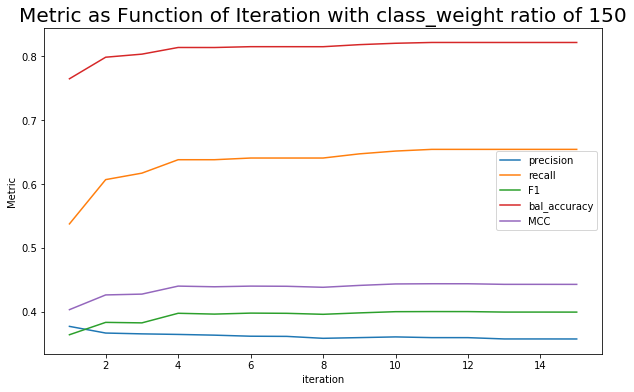

In [15]:
# #define optimal parameters
# n_estimator_opt = params_opt[0]
# max_feature_opt = params_opt[1]
# depth_opt = params_opt[2]
# min_split_opt = params_opt[3]
# min_leaf_opt = params_opt[4]
# bootstrap_opt = params_opt[5]
iteration_1 = []
iteration_final = []
master_forest = []
master_X_train_scaled = []
master_self_labs = []
master_testing_data = []

#weight_1_ops = [1,5,10,25,50,100,150,250,400,500] #all options
weight_1_ops = [150]

for weight_1_option in tqdm(weight_1_ops):
    n_estimator_opt = 200
    max_feature_opt = 'auto'
    depth_opt = 10
    min_split_opt = 2
    min_leaf_opt = 1
    bootstrap_opt = True
    weight_0 = 1
    weight_1 = weight_1_option #high precision model has this = 1; alternatively, balanced model has this = 500

    viable_new2 = viable_new[9:16]+viable_new[17:]
    #viable_new2 = viable_new[:3]+viable_new[4:7]+viable_new[8:9]

    recursive_frames = []

    stream_name_rf = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150
    self_labs = []

    precisions = []
    recalls = []
    f1s_weights = []

    training_streams = []
    testing_streams = []
    correct_X = []
    incorrect_X2 = []
    
    X_correct_cum = {}
    X_incorrect_cum = {}
    X2_correct_cum = {}
    X2_incorrect_cum = {}

    for stream_name in tqdm(viable_new2):

        stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
        stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
        #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
        #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

        #stars known to model
        stream_train = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==True]
        stream_train['stream_mask'] = True
        #unknown to model
        stream_test = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==False]
        stream_test['stream_mask'] = True  

        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

        train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

        noise_test = pd.read_csv(name_test, index_col = 'source_id')
        noise_points = pd.read_csv(name_train, index_col = 'source_id')
        
        #remove points from training pool that are already in the test set so that we aren't training/testing on same data
        noise_points = noise_points[~noise_points.index.isin(noise_test.index)]

        #add back the test points into the muck and assume they're background stars from which to draw
        noise_points = noise_points.append(stream_test, ignore_index = False) #sort = True
        #train_points = len(stream_train) * multiple
        train_points = len(stream_train) * multiple

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]



        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = stream_test.append(noise_test, ignore_index = False)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        #Convert to Angular Coordinates
        #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
        #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
        #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

        deg2rad = lambda deg: deg/180.*np.pi

        #Convert data to angular velocities
        training_data['ra_rad'] = deg2rad(training_data['ra'])
        training_data['dec_rad'] = deg2rad(training_data['dec'])

        training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
        training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
        training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

        testing_data['ra_rad'] = deg2rad(testing_data['ra'])
        testing_data['dec_rad'] = deg2rad(testing_data['dec'])

        testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

        testing_data_eval, testing_data_selflab = train_test_split(testing_data, test_size=0.5)
        self_labs.append(testing_data_selflab)
        master_self_labs.append(self_labs)
        master_testing_data.append(testing_data)

        #differentiate training and test data's X and y variables
        #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_train = training_data.stream_mask

        #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_test = testing_data.stream_mask


        #differentiate training and test data's X and y variables
        #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_train = training_data.stream_mask

        ##eval
        #X_test = testing_data_eval[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test_eval = testing_data_eval[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test_eval = testing_data_eval.stream_mask

        ##self_lab
        #X_test = testing_data_selflab[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test_selflab = testing_data_selflab[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test_selflab = testing_data_selflab.stream_mask


        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled_eval = scaler.fit(X_train).transform(X_test_eval)
        X_test_scaled_selflab = scaler.fit(X_train).transform(X_test_selflab)

        #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
    #     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
    #     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

    #     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
    #     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_train_scaled = np.array(X_train_scaled)

    #     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
    #     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_test_scaled = np.array(X_test_scaled)    

        precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled_selflab, y_train, y_test_selflab, 
                                                                               n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                               min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                               min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                               max_leaf_nodes = None, 
                                                                               min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                               oob_score = False, n_jobs = 1, 
                                                                               random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1}) #"balanced"

        master_forest.append(forest)
        master_X_train_scaled.append(X_train_scaled)
        #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = testing_data_selflab[y_test_selflab & y_pred] #predicted in cluster (true positives)
        X_incorrect = testing_data_selflab[y_test_selflab & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = testing_data_selflab[~y_test_selflab & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = testing_data_selflab[~y_test_selflab & y_pred] #predicted in cluster (false positive)
        
        X_correct_cum[stream_name] = X_correct
        X_incorrect_cum[stream_name] = X_incorrect
        X2_correct_cum[stream_name] = X2_correct
        X2_incorrect_cum[stream_name] = X2_incorrect
        
        stream_name_rf.append(stream_name)
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))
        y_preds.append(y_pred)
        testing_datas.append(testing_data_selflab)
        training_datas.append(training_data)
        training_streams.append(stream_train)
        testing_streams.append(stream_test)
        correct_X.append(X_correct)
        incorrect_X2.append(X2_incorrect)
        

    final_result_rf = pd.DataFrame()
    final_result_rf['stream']= stream_name_rf
    final_result_rf['true_positives']=true_positives
    final_result_rf['false_positives']=false_positives
    final_result_rf['true_negatives']=true_negatives
    final_result_rf['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf['precision'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_positives)
    final_result_rf['recall'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_negatives)
    final_result_rf['f1'] = 2*(final_result_rf.precision * final_result_rf.recall)/(final_result_rf.precision + final_result_rf.recall)
    #beta = 0.1
    #final_result_rf['f1_prec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 0.5
    final_result_rf['f0.5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 2
    final_result_rf['f2'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    final_result_rf['bal_acc']= (final_result_rf.true_positives/(final_result_rf.true_positives + final_result_rf.false_negatives)+ final_result_rf.true_negatives/(final_result_rf.true_negatives+final_result_rf.false_positives))/2
    final_result_rf['matt_coef'] = (final_result_rf.true_positives * final_result_rf.true_negatives - final_result_rf.false_positives * final_result_rf.false_negatives)/((final_result_rf.true_positives + final_result_rf.false_positives)*(final_result_rf.true_positives + final_result_rf.false_negatives)*(final_result_rf.true_negatives + final_result_rf.false_positives)*(final_result_rf.true_negatives + final_result_rf.false_negatives))**0.5
    #beta = 10
    #final_result_rf['f1_rec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)

    recursive_frames.append(final_result_rf)
    iteration_1.append(final_result_rf)

    #do the recursion more times
    for i in tqdm(range(1,15)): #do it 14 more times
        plot_permit = 'no'
        if i == 14:
            plot_permit = 'yes'
        training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf_updated, X_correct_cum, X2_incorrect_cum, forest = rf_recursion(training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit, X_correct_cum, X2_incorrect_cum)
        recursive_frames.append(final_result_rf_updated)
    iteration_final.append(final_result_rf_updated)
    
    #replace NaN values with 0
    recursive_frames_adj = []
    for i in recursive_frames:
        recursive_frames_adj.append(i.fillna(0))

    #plot performance
    x_vals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    precs_plt = [recursive_frames_adj[i-1].mean().precision for i in x_vals]
    recs_plt = [recursive_frames_adj[i-1].mean().recall for i in x_vals]
    f1s_plt = [recursive_frames_adj[i-1].mean().f1 for i in x_vals]
    bal_acc_plt = [recursive_frames_adj[i-1].mean().bal_acc for i in x_vals]
    matt_coeff_plt = [recursive_frames_adj[i-1].mean().matt_coef for i in x_vals]

    plt.figure(figsize = (10,6))
    plt.plot(x_vals, precs_plt,label= 'precision')
    plt.plot(x_vals, recs_plt, label = 'recall')
    plt.plot(x_vals, f1s_plt, label = 'F1')
    plt.plot(x_vals, bal_acc_plt, label = 'bal_accuracy')
    plt.plot(x_vals, matt_coeff_plt, label = 'MCC')
    plt.xlabel('iteration')
    plt.ylabel('Metric')
    plt.title('Metric as Function of Iteration with class_weight ratio of '+str(weight_1), fontsize = 20)
    plt.legend()

# Analyze Results

## Obtain Feature Importances for Each Stream

Feature ranking:
1. feature 6 (0.289473)
2. feature 2 (0.265121)
3. feature 7 (0.114847)
4. feature 1 (0.077339)
5. feature 8 (0.068991)
6. feature 0 (0.053306)
7. feature 3 (0.045108)
8. feature 4 (0.029230)
9. feature 9 (0.028615)
10. feature 5 (0.027971)


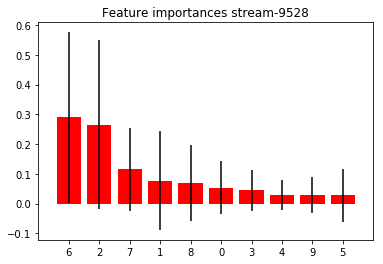

Feature ranking:
1. feature 3 (0.221012)
2. feature 8 (0.180226)
3. feature 2 (0.146057)
4. feature 7 (0.131395)
5. feature 1 (0.088264)
6. feature 6 (0.081207)
7. feature 4 (0.077989)
8. feature 0 (0.029932)
9. feature 5 (0.023474)
10. feature 9 (0.020445)


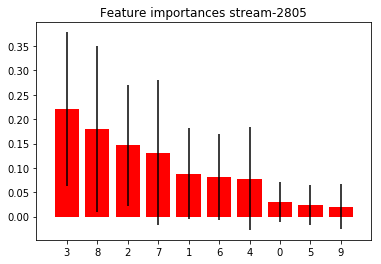

Feature ranking:
1. feature 2 (0.238151)
2. feature 3 (0.201454)
3. feature 6 (0.192636)
4. feature 8 (0.120704)
5. feature 0 (0.078551)
6. feature 7 (0.060872)
7. feature 4 (0.055589)
8. feature 1 (0.030067)
9. feature 5 (0.013624)
10. feature 9 (0.008352)


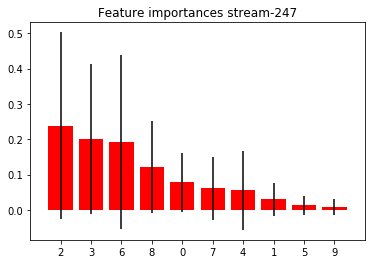

Feature ranking:
1. feature 3 (0.251534)
2. feature 4 (0.151048)
3. feature 7 (0.147275)
4. feature 2 (0.146709)
5. feature 8 (0.113297)
6. feature 6 (0.095016)
7. feature 5 (0.035396)
8. feature 9 (0.030939)
9. feature 0 (0.015858)
10. feature 1 (0.012926)


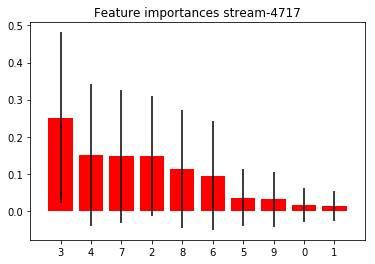

Feature ranking:
1. feature 0 (0.357924)
2. feature 4 (0.225350)
3. feature 3 (0.123582)
4. feature 2 (0.099321)
5. feature 6 (0.085007)
6. feature 8 (0.045243)
7. feature 5 (0.030989)
8. feature 1 (0.024890)
9. feature 7 (0.006064)
10. feature 9 (0.001631)


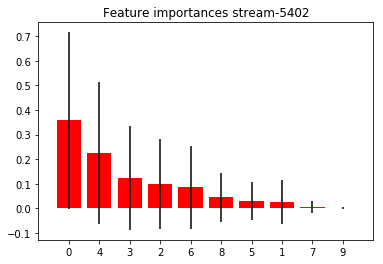

Feature ranking:
1. feature 3 (0.317894)
2. feature 4 (0.252982)
3. feature 6 (0.096237)
4. feature 1 (0.078807)
5. feature 7 (0.074961)
6. feature 2 (0.050645)
7. feature 0 (0.043497)
8. feature 8 (0.034844)
9. feature 9 (0.031828)
10. feature 5 (0.018305)


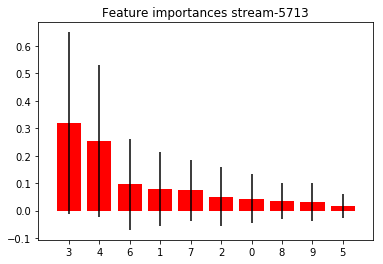

Feature ranking:
1. feature 6 (0.220073)
2. feature 8 (0.216160)
3. feature 2 (0.178350)
4. feature 7 (0.116623)
5. feature 3 (0.107937)
6. feature 1 (0.062922)
7. feature 4 (0.048432)
8. feature 9 (0.028514)
9. feature 5 (0.012328)
10. feature 0 (0.008661)


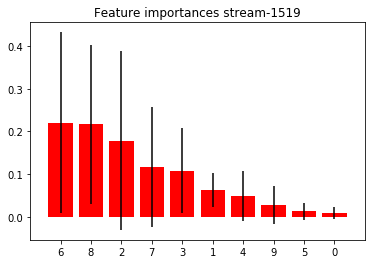

Feature ranking:
1. feature 2 (0.186473)
2. feature 6 (0.168424)
3. feature 7 (0.123127)
4. feature 3 (0.115036)
5. feature 1 (0.102430)
6. feature 4 (0.092068)
7. feature 8 (0.075109)
8. feature 0 (0.064265)
9. feature 5 (0.046766)
10. feature 9 (0.026302)


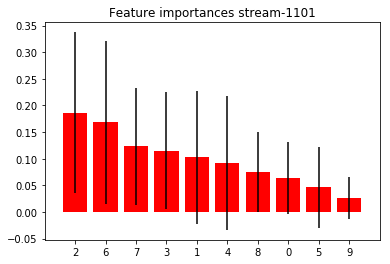

In [51]:
for i in range(8):
    importances = master_forest[i].feature_importances_
    std = np.std([tree.feature_importances_ for tree in master_forest[i].estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(master_X_train_scaled[i].shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title('Feature importances '+viable_new2[i])
    plt.bar(range(master_X_train_scaled[i].shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(master_X_train_scaled[i].shape[1]), indices)
    plt.xlim([-1, master_X_train_scaled[i].shape[1]])
    plt.show()


## Convert N/A Values to 0 (Useful for Calculating Metrics)

In [12]:
iteration_1_adj = []
iteration_final_adj = []
for i in range(10):
    test = iteration_1[i]
    test2 = test.fillna(0)
    iteration_1_adj.append(test2)
    test = iteration_final[i]
    test2 = test.fillna(0)
    iteration_final_adj.append(test2)

## Show Table of RF and Recurrent RF Result for Each Stream (One Iteration)

In [17]:
#Random Forest Result
iteration_1[0]

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f0.5,f2,bal_acc,matt_coef
0,stream-3775,16,68,7362,20,0.190476,0.444444,0.266667,0.215054,0.350877,0.717646,0.285891
1,stream-5489,124,501,26870,48,0.198400,0.720930,0.311167,0.232036,0.472201,0.851313,0.371683
2,stream-8137,170,493,37464,51,0.256410,0.769231,0.384615,0.295858,0.549451,0.878121,0.439181
3,stream-1698,17,2,9376,37,0.894737,0.314815,0.465753,0.653846,0.361702,0.657301,0.529385
4,stream-1667,8,11,7785,43,0.421053,0.156863,0.228571,0.314961,0.179372,0.577726,0.254164
5,stream-1012,51,122,10523,16,0.294798,0.761194,0.425000,0.335968,0.578231,0.874867,0.468915
6,stream-178,97,155,25334,66,0.384921,0.595092,0.467470,0.414176,0.536504,0.794505,0.474544


In [18]:
#Recurrent Random Forest Result
iteration_final[0]

,stream,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f0.5,f2,bal_acc,matt_coef
0,stream-3775,21,112,7318,15,0.157895,0.583333,0.248521,0.184859,0.379061,0.784130,0.297595
1,stream-5489,150,710,26661,22,0.174419,0.872093,0.290698,0.207641,0.484496,0.923077,0.383259
2,stream-8137,179,642,37315,42,0.218027,0.809955,0.343570,0.255350,0.524927,0.896520,0.414744
3,stream-1698,31,4,9374,23,0.885714,0.574074,0.696629,0.798969,0.617530,0.786824,0.711817
4,stream-1667,13,19,7777,38,0.406250,0.254902,0.313253,0.363128,0.275424,0.626232,0.318334
5,stream-1012,53,138,10507,14,0.277487,0.791045,0.410853,0.318893,0.577342,0.889040,0.463543
6,stream-178,113,182,25307,50,0.383051,0.693252,0.493450,0.420700,0.596621,0.843056,0.511334


In [79]:
#Mean Statistics for Random Forest
iteration_1[0].mean()

true_positives       101.500000
false_positives      239.500000
true_negatives     25028.000000
false_negatives       47.375000
precision              0.566859
recall                 0.539421
f1                     0.472833
f0.5                   0.500940
f2                     0.487537
bal_acc                0.766901
matt_coef              0.505516
dtype: float64

In [81]:
#Mean Statistics for Recurrent Random Forest
iteration_final[0].mean()

true_positives       113.000000
false_positives      319.375000
true_negatives     24948.125000
false_negatives       35.875000
precision              0.471322
recall                 0.669231
f1                     0.493564
f0.5                   0.469862
f2                     0.561737
bal_acc                0.830384
matt_coef              0.525000
dtype: float64